# The Continuous Epistasis Model

The following code trains and evaluates the continuous epistasis model. It uses single- and pairwise CRISPRi perturbations to relate gene expression (relative repression) to growth rate. Single-gene expression-growth rate relationships are modeled with two-parameter sigmoidal functions, and gene-gene coupling is accounted for using two coupling constants. The resulting model is assessed by its RMSD relative to a coupling-insensitive Null model. A subsampled model trained on only 20% of the available pairwise CRISPRi data performs similarly to the full model (irrespective of subsampling strategy), supporting a sparse sampling strategy as a way to improve throughput in future experiments.

1/19/23 - Ryan Otto
2/16/23 - Ryan Otto

### Import packages and libraries

In [1]:
import numpy as np
import random
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.utils import resample as bootstrap
import seaborn as sns
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '231012'
output_path = 'intermediate_files'
bootstrap_path = 'input_files/bootstrapped_files'
optimization_path = 'input_files/optimization_files'
figure_path = 'Figures'
gene_names = ['dapA', 'dapB', 'gdhA', 'gltB', 'folA', 'thyA', 'glyA', 'purN', 'purL']

### Import data

In [3]:
with open(f'{output_path}/231012_df_growth_pool_filt_rescale.pickle', 'rb') as handle:
    growth_df_rescale = pickle.load(handle)
with open(f'{output_path}/231012_df_growth_pool_filt_sem_rescale.pickle', 'rb') as handle:
    sem_df_rescale = pickle.load(handle)
with open(f'{output_path}/231012_df_growth_pool_filt_std_rescale.pickle', 'rb') as handle:
    std_df_rescale = pickle.load(handle)
with open(f'{output_path}/231012_repression_mean.pickle', 'rb') as handle:
    qPCR_vals = pickle.load(handle)
with open(f'{output_path}/231012_repression_ind.pickle', 'rb') as handle:
    qPCR_ind = pickle.load(handle)
with open(f'{output_path}/231012_repression_sem.pickle', 'rb') as handle:
    qPCR_sem = pickle.load(handle)
with open(f'{output_path}/231012_dict_growth_pool.pickle', 'rb') as handle:
    dict_growth_pool = pickle.load(handle)
with open(f'{output_path}/231012_pairwise_gr_min.pickle', 'rb') as handle:
    pairwise_gr_min = pickle.load(handle)
for guide in ['gdhA_1_42_B_MM14', 'gdhA_3_216_B_MM8']:  # Off target guides, as shown in notebook 2
    sp = guide.split('_')
    qPCR_vals[sp[0]].pop(guide)
    qPCR_sem[sp[0]].pop(guide)
with open(f'{bootstrap_path}/230303_hill_est.pickle', 'rb') as handle:
    hill_est = pickle.load(handle)
with open(f'{bootstrap_path}/230303_pair_avals.pickle', 'rb') as handle:
    pair_avals = pickle.load(handle)
with open(f'{bootstrap_path}/230303_pair_avals_sub.pickle', 'rb') as handle:
    pair_avals_sub = pickle.load(handle)
with open(f'{bootstrap_path}/230303_pair_avals_corners.pickle', 'rb') as handle:
    pair_avals_corners = pickle.load(handle)

### Define analysis functions

In [4]:
def exp_extract(exp_growth_df, rep_mean, gene_name_1, gene_name_2):
    """Function to sort and extract relevant growth rates for a given pair of genes.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    gene_name_1: Name of one gene in the pair
    gene_name_2: Name of the other gene in the pair
    Returns:
    pair_data: Pairwise expression-growth rate data for the gene pair
    gene1: Gene titrated along the index of the pairwise data
    gene2: Gene titrated along the columns of the pairwise data
    """
    for guide in exp_growth_df.index:
        # The following logic establish which gene lies on which axis
        if guide.startswith(gene_name_1):
            gene1 = gene_name_1
            gene2 = gene_name_2
        elif guide.startswith(gene_name_2):
            gene1 = gene_name_2
            gene2 = gene_name_1
    gene1_sgRNAs = list(rep_mean[gene1])
    gene2_sgRNAs = list(rep_mean[gene2])
    pair_data = pd.DataFrame(np.full((len(gene1_sgRNAs), len(gene2_sgRNAs)), np.nan), gene1_sgRNAs, gene2_sgRNAs)
    for sgRNA2 in gene2_sgRNAs:
        for sgRNA1 in gene1_sgRNAs:
            if sgRNA1 == 'negC_rand_42':  # Nontargeting sgRNAs are indexed differently
                 pair_data.loc['negC_rand_42', sgRNA2] = exp_growth_df.loc[sgRNA2, 'negC_rand_42']
            else:
                pair_data.loc[sgRNA1, sgRNA2] = exp_growth_df.loc[sgRNA1, sgRNA2]
    # Sort rows and columns by repression intensity
    pair_data.loc[len(pair_data.index)] = [rep_mean[gene2][sgRNA] for sgRNA in pair_data.columns]
    pair_data = pair_data.sort_values(by=len(pair_data.index)-1, axis=1, ascending=True)
    pair_data = pair_data.drop(labels=len(pair_data.index)-1, axis=0)
    pair_data[len(pair_data.columns)] = [rep_mean[gene1][sgRNA] for sgRNA in pair_data.index]
    pair_data = pair_data.sort_values(by=len(pair_data.columns)-1, axis=0, ascending=True)
    pair_data = pair_data.drop(labels=len(pair_data.columns)-1, axis=1)
    return pair_data, gene1, gene2


def growth_rate(r, Ro, n):
    """Calculates an expected growth rate using a sigmoidal formula.
    Arguments:
    r: Repression level to use when predicting growth rates
    Ro: Repression level at half-maximal growth rate
    n: Steepness of the repression-growth rate function
    Returns:
    g_rate: Predicted growth rate
    """
    if len(r) > 1:  # Check if repression values are a list or just an individual value
        try:
            g_rate = [(1 / (1+math.exp(n*(repression-Ro)))) for repression in r]
        except:
            print('Math range')
            g_rate = [0] * len(r)
    else:
        g_rate = 1 / (1+math.exp(n*(r-Ro)))
    return g_rate

In [5]:
def calc_avals(pairwise_data, rep_mean, hill_params, penalty=0):
    """Optimizes coupling constants for a given pair of genes using pairwise expression-growth rate data.
    Arguments:
    pairwise_data: Pairwise CRISPRi growth rate data to use when fitting a values
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    pentalty: Regularization term to penalize the absolute value of coupling constants
    Returns:
    pair_avals: Coupling constants for each gene pair
    """
    pair_avals = {}
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            gene1_KD = [rep_mean[gene_pair[1]][treatment1] for treatment1 in pairwise_data[gene_pair].index]
            gene2_KD = [rep_mean[gene_pair[0]][treatment2] for treatment2 in pairwise_data[gene_pair].columns]
            pair_avals[gene_pair] = least_squares(residuals_growthPairs, x0=[0, 0], bounds=[(-1.2, -1.2), (10, 10)],
                                        args=(pairwise_data[gene_pair].values, gene1_KD, gene2_KD,
                                        hill_params[gene_2], hill_params[gene_1], penalty)).x
    return pair_avals


def residuals_growthPairs(avals, y, rep_1, rep_2, p1, p2, penalty):
    """Calculate residuals between pairwise growth rate measurements and predictions.
    The goal is to minimize the regularized RMSD of our predictions. To regularize,
    we add a penalty term based on the absolute values of each parameter in avals.
    Finally, we take the square root of this regularized RMSD, as least_squares technically
    optimizes the squared residual, but we want to minimize the value directly.
    The result of optimization is only numerically (<10**-8) different without the square root.
    Arguments:
    avals: Coupling constants between the genes of interest
    y: True pairwise growth rates
    rep_1: All repression values for gene 1
    rep_2: All repression values for gene 2
    p1: Growth rate parameters Ro and n for gene 1
    p2: Growth rate parameters Ro and n for gene 2
    penalty: Regularization term to penalize the absolute value of coupling constants
    Returns:
    err: Regularized root mean square error between the predicted and measured growth rates
    """
    gpair = pairGrowthRates(avals, rep_1, rep_2, p1, p2)
    mask = ~np.isnan(y.flatten())  # Use to mask nans from input data
    gpair = gpair.flatten()[mask]
    y = y.flatten()[mask]
    err = y - gpair
    err = np.sqrt(nanrms(err) + sum([penalty*abs(x) for x in avals]))
    return err


def pairGrowthRates(avals, rep_1, rep_2, p1, p2):
    """Calculate predicted pairwise growth rates following two coupled gene knockdowns.
    Arguments:
    avals: Coupling constants between the genes of interest
    rep_1: All repression values for gene 1
    rep_2: All repression values for gene 2
    p1: Growth rate parameters Ro and n for gene 1
    p2: Growth rate parameters Ro and n for gene 2
    Returns:
    gr_pair: Predicted pairwise growth rates
    """
    Ro1, n1 = p1
    Ro2, n2 = p2
    r1eff, r2eff, resid_1, resid_2 = solveReff(avals, rep_1, rep_2, Ro1, Ro2)
    # On rare occassions, early rounds of optimization can generate abnormally large effective repression values
    # This logic manually "resets" the optimization, and testing has shown that this is sufficient
    if max([abs(x) for x in r1eff.flatten()]) > 10 or max([abs(x) for x in r2eff.flatten()]) > 10:
        return np.zeros(np.shape(r1eff))
    gr1, gr2, gr_pair = np.zeros(np.shape(r1eff)), np.zeros(np.shape(r2eff)), np.zeros(np.shape(r1eff))
    for i, r1 in enumerate(r1eff):
        gr1[i, :] = growth_rate(r1, Ro1, n1)
    for i, r2 in enumerate(r2eff):
        gr2[i, :] = growth_rate(r2, Ro2, n2)
    for r1 in range(np.shape(r1eff)[0]):
        for r2 in range(np.shape(r1eff)[1]):
            gr_pair[r1, r2] = gr1[r1, r2] * gr2[r1, r2]
    return gr_pair


def solveReff(avals, rep_1, rep_2, Ro_1, Ro_2):
    """Solve for the effective repression of two CRISPRi perturbations given two coupling constants.
    Arguments:
    avals: Coupling constants between the genes of interest
    rep_1: All repression values for gene 1
    rep_2: All repression values for gene 2
    Ro: Growth rate parameter Ro for gene 1
    Ro: Growth rate parameter Ro for gene 2
    Returns:
    r1eff: 2D array of the first perturbation's relative repression after accounting for coupling
    r1eff: 2D array of the second perturbation's relative repression after accounting for coupling
    resids_r1: List of residuals for the first perturbation, returned for troubleshooting and optimization
    resids_r2: List of residuals for the second perturbation, returned for troubleshooting and optimization
    """
    r1eff = np.tile(np.array(rep_1), (len(rep_2), 1)).T
    r2eff = np.tile(np.array(rep_2), (len(rep_1), 1))
    r1update, r2update = np.zeros(np.shape(r1eff)), np.zeros(np.shape(r2eff))
    resids, eps, count = np.inf, 0.01, 0  # Initialize sum of residuals, desired final residual, and count iterator
    resids_r1, resids_r2 = [], []
    # Iteratively reduce the residuals using the update formulas
    # If the desired residual is not reached, exit after 100 iterations
    while resids > eps and count < 100:
        for i, r1 in enumerate(rep_1):
            for j, r2 in enumerate(rep_2):
                r1update[i, j] = r1 / (1 + avals[0]*((r2eff[i, j]/Ro_2)/(1 + (r2eff[i, j]/Ro_2))))
                r2update[i, j] = r2 / (1 + avals[1]*((r1eff[i, j]/Ro_1)/(1 + (r1eff[i, j]/Ro_1))))
        resids_r1.append(np.sum(abs(r1eff - r1update)))
        resids_r2.append(np.sum(abs(r2eff - r2update)))
        resids = resids_r1[-1] + resids_r2[-1]
        r1eff = np.copy(r1update)
        r2eff = np.copy(r2update)
        count += 1
    return r1eff, r2eff, resids_r1, resids_r2


def nanrms(x, axis=None):
    """Self-defined root mean square function. Used for convenience and consistency.
    Arguments:
    x: Array of residuals
    axis: In case of an array of arrays, enter the desired axis to calculate across
    Directly returns the RMSD of the residuals provided
    """
    return np.sqrt(np.nanmean(x**2, axis=axis))


def pred_mult_calculate(exp_growth_df):
    """Calculate predicted pairwise growth rates using a multiplicative Bliss model
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    Returns:
    mult_gr: Predicted growth rates from a multiplicative Bliss model
    """
    mult_gr = pd.DataFrame(np.full((len(exp_growth_df.index), len(exp_growth_df.columns)), np.nan),
                           exp_growth_df.index, exp_growth_df.columns)
    for sgRNA1 in exp_growth_df.index:
        for sgRNA2 in exp_growth_df.columns:
            mult_gr.loc[sgRNA1, sgRNA2] = exp_growth_df['negC_rand_42'][sgRNA1]*exp_growth_df[sgRNA2]['negC_rand_42']
    return mult_gr

In [6]:
def calc_pair_gr(exp_growth_df, rep_mean, avals, pairwise_data, hill_params):
    """Calculate growth rates following pairwise CRISPRi for all gene pairs.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    avals: Coupling constants for each gene pair
    pairwise_data: Pairwise CRISPRi growth rate data
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    Returns:
    pred_dict: All predicted growth rates
    """
    pred_dict = {}
    for gene_pair in avals:
        pair_gr, gene1, gene2 = exp_extract(exp_growth_df, rep_mean, gene_pair[0], gene_pair[1])
        gene1_KD = [rep_mean[gene_pair[1]][treatment1] for treatment1 in pairwise_data[gene_pair].index]
        gene2_KD = [rep_mean[gene_pair[0]][treatment2] for treatment2 in pairwise_data[gene_pair].columns]
        pred_dict[gene_pair] = pairGrowthRates(avals[gene_pair], gene1_KD, gene2_KD, hill_params[gene1],
                                               hill_params[gene2])
    return pred_dict


def heat_map(df, ax=None, xticks=None, yticks=None, xlabel=None, ylabel=None, vmin=0, vmax=2, cmap='PuOr_r'):
    """Creates a heat map. Function made for ease of use.
    Arguments: 
    df: Data to plpot
    ax: Axes object, if available
    xticks, yticks, xlabel, ylabel, vmin, vmax, cmap: Self-explanatory
    Returns:
    ax: Resulting axes object
    cb: Colorbar
    """
    if not ax:
        ax = plt.gca()
    cb = ax.imshow(df, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    if xticks:
        ax.set_xticks(np.arange(len(xticks)))
        ax.set_xticklabels(xticks, fontsize=18)
        ax.xaxis.tick_top()
    else:
        ax.set_xticks([])
    if yticks:
        ax.set_yticks(np.arange(len(yticks)))
        ax.set_yticklabels(yticks, fontsize=18)
    else:
        ax.set_yticks([])
    ax.spines[['top', 'right']].set_visible(True)
    ax.set_facecolor("darkgrey")
    return ax, cb


def cross_validate(pairwise_data, subsampled_data, sub_prediction):
    """Calculates the error of predicted growth rates in a holdout data set
    Arguments:
    pairwise_data: Pairwise CRISPRi growth rate data
    subsampled_data: Subsampled pairwise CRISPRi growth rate data used in training
    sub_prediction: Predicted growth rates
    Returns:
    rms_dict_sub: Dictionary containing RMSD metrics for all pairwise predictions
    """
    rms_dict_sub = {}
    for gene_pair in pairwise_data:
        sub_err = []
        for j, sgRNA1 in enumerate(list(pairwise_data[gene_pair].index)):
            for k, sgRNA2 in enumerate(list(pairwise_data[gene_pair].columns)):
                if np.isnan(subsampled_data[gene_pair].loc[sgRNA1, sgRNA2]):  # If not in training set
                    sub_err.append(pairwise_data[gene_pair].loc[sgRNA1, sgRNA2] - sub_prediction[gene_pair][j, k])
        rms_dict_sub[gene_pair] = nanrms(np.array(sub_err))
    return rms_dict_sub

In [7]:
def subsample_gr(exp_growth_df, rep_mean, hill_params, strategy, frac_drop=0):
    """A convenience function to enable different forms of subsampling. This will branch into the functions below.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    strategy: A keyword argument indicating which subsampling strategy will be utilized.
              If invalid, prints a message and likely errors out, as nothing is returned
    frac_drop: A fraction (between 0 and 1) of the pairwise data to remove for subsampling
    Directly returns the result of one subsampling function, or nothing
    """
    if strategy == 'pairs':
        return subsample_gr_pairs(exp_growth_df, rep_mean, hill_params, frac_drop)
    elif strategy == 'spread':
        return subsample_gr_spread(exp_growth_df, rep_mean, hill_params, frac_drop)
    elif strategy == 'sgRNAs':
        return subsample_gr_sgRNAs(exp_growth_df, rep_mean, hill_params, frac_drop)
    elif strategy == 'corners':
        return subsample_gr_corners(exp_growth_df, rep_mean, hill_params)
    else:
        print('Invalid subsampling strategy')
        return


def subsample_gr_pairs(exp_growth_df, rep_mean, hill_params, frac_drop):
    """Our most widely used subsampling strategy, which independently subsamples pairwise growth
    rate data for each gene pair. Generates three groups of pairwise expression-growth rate data.
    The first group includes all data gathered in the pairwise experiment.
    The second contains only growth rates following two targeting CRISPRi perturbations.
    The final group has only pairwise CRISPRi data, and is subsampled according to frac_drop.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    frac_drop: A fraction (between 0 and 1) of the pairwise data to remove for subsampling
    Returns:
    full_data: The first group of data, containing all measurements
    pairwise_data: The second group of data, containing only pairwise measurements
    subsampled_data: The third group of data, containing subsampled pairwise measurements
    """
    full_data, pairwise_data, subsampled_data = {}, {}, {}
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            full_data[gene_pair], gene1, gene2 = exp_extract(exp_growth_df, rep_mean, gene_1, gene_2)
            ind_names, col_names = full_data[gene_pair].index, full_data[gene_pair].columns
            gene1_KD = [rep_mean[gene_pair[1]][treatment1] for treatment1 in full_data[gene_pair].index]
            gene2_KD = [rep_mean[gene_pair[0]][treatment2] for treatment2 in full_data[gene_pair].columns]
            # The following subsamples data from the complete landscape
            pairwise_data[gene_pair] = full_data[gene_pair].copy()  # Don't change the original
            pairwise_data[gene_pair].loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
            pairwise_data[gene_pair]['negC_rand_42'] = np.nan  # Remove first-order perturbations
            subsampled_data[gene_pair] = pairwise_data[gene_pair].copy()  # Don't change the original
            negC_row = list(ind_names).index('negC_rand_42')  # Don't subsample from first-order perturbations
            negC_col = list(col_names).index('negC_rand_42')  # Don't subsample from first-order perturbations
            tot_ind = list(range((len(ind_names)-1)*(len(col_names)-1)))  # List of all indexes
            np.random.shuffle(tot_ind)  # Randomize index order
            # Drop the first frac_drop percent, but not every value
            for drop in range(int(np.ceil(len(tot_ind)*frac_drop))):
                row_ind, col_ind = int(tot_ind[drop]%(len(ind_names)-1)), \
                                   int(np.floor(tot_ind[drop]/(len(ind_names)-1)))
                if row_ind >= negC_row:  # Renumber to skip the first-order perturbations
                    row_ind += 1
                if col_ind >= negC_col:  # Renumber to skip the first-order perturbations
                    col_ind += 1
                row, col = ind_names[row_ind], col_names[col_ind]
                subsampled_data[gene_pair][col][row] = np.nan
                if sum(~np.isnan(subsampled_data[gene_pair].values.flatten())) == 0:  # If all points were removed
                    # Add in a value that doesn't affect model fit but avoids a finite residual error
                    subsampled_data[gene_pair].loc['negC_rand_42', 'negC_rand_42'] = 1
    return full_data, pairwise_data, subsampled_data


def subsample_gr_spread(exp_growth_df, rep_mean, hill_params, frac_drop):
    """A subsampling strategy that independently subsamples pairwise data from across the
    entire landscape. As such, it can remove all pairwise data from some gene pairs at random.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    frac_drop: A fraction (between 0 and 1) of the pairwise data to remove for subsampling
    Returns:
    subsampled_data: Subsampled pairwise growth rate measurements
    """
    full_data, pairwise_data, subsampled_data = {}, {}, {}
    temp_exp_growth_df = exp_growth_df.copy()
    temp_exp_growth_df.loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
    temp_exp_growth_df['negC_rand_42'] = np.nan  # Remove first-order perturbations
    ind_names, col_names = temp_exp_growth_df.index, temp_exp_growth_df.columns      
    negC_row = list(ind_names).index('negC_rand_42')  # Don't subsample from first-order perturbations
    negC_col = list(col_names).index('negC_rand_42')  # Don't subsample from first-order perturbations
    tot_ind = list(range((len(ind_names)-1)*(len(col_names)-1)))  # List of all indexes
    np.random.shuffle(tot_ind)  # Randomize index order
    for drop in range(int(np.ceil(len(tot_ind)*frac_drop))):  # Drop the first frac_drop percent
        row_ind, col_ind = int(tot_ind[drop]%(len(ind_names)-1)), \
                           int(np.floor(tot_ind[drop]/(len(ind_names)-1)))
        if row_ind >= negC_row:  # Renumber to skip the first-order perturbations
            row_ind += 1
        if col_ind >= negC_col:  # Renumber to skip the first-order perturbations
            col_ind += 1
        row, col = ind_names[row_ind], col_names[col_ind]
        temp_exp_growth_df[col][row] = np.nan
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            full_data[gene_pair], _, _ = exp_extract(exp_growth_df, rep_mean, gene_1, gene_2)
            pairwise_data[gene_pair] = full_data[gene_pair].copy()  # Don't change the original
            pairwise_data[gene_pair].loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
            pairwise_data[gene_pair]['negC_rand_42'] = np.nan  # Remove first-order perturbations
            subsampled_data[gene_pair], _, _ = exp_extract(temp_exp_growth_df, rep_mean, gene_1, gene_2)
            if sum(~np.isnan(subsampled_data[gene_pair].values.flatten())) == 0:  # If all points were removed
                # Add in a value that doesn't affect model fit but avoids a finite residual error
                subsampled_data[gene_pair].loc['negC_rand_42', 'negC_rand_42'] = 1
    return full_data, pairwise_data, subsampled_data


def subsample_gr_sgRNAs(exp_growth_df, rep_mean, hill_params, frac_drop):
    """A subsampling strategy that removes entire sgRNA rows/columns rather than individual data points.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    frac_drop: A fraction (between 0 and 1) of the pairwise data to remove for subsampling
    Returns:
    subsampled_data: Subsampled pairwise measurements
    """
    full_data, pairwise_data, subsampled_data = {}, {}, {}
    temp_exp_growth_df = exp_growth_df.copy()
    temp_exp_growth_df.loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
    temp_exp_growth_df['negC_rand_42'] = np.nan  # Remove first-order perturbations
    perc_dropped = (1-np.sqrt(1-frac_drop))  # Subsampling a percentage of the pairwise data, not the # of sgRNAs
    for gene in rep_mean:
        temp_sgRNAs = list(rep_mean[gene].keys())
        temp_sgRNAs.remove('negC_rand_42')
        np.random.shuffle(temp_sgRNAs)
        dropped_sgRNAs = temp_sgRNAs[:int(np.ceil(len(temp_sgRNAs)*perc_dropped))]
        for sgRNA in dropped_sgRNAs:
            temp_exp_growth_df.loc[sgRNA] = np.nan
            temp_exp_growth_df[sgRNA] = np.nan
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            full_data[gene_pair], _, _ = exp_extract(exp_growth_df, rep_mean, gene_1, gene_2)
            pairwise_data[gene_pair] = full_data[gene_pair].copy()  # Don't change the original
            pairwise_data[gene_pair].loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
            pairwise_data[gene_pair]['negC_rand_42'] = np.nan  # Remove first-order perturbations
            subsampled_data[gene_pair], gene1, gene2 = exp_extract(temp_exp_growth_df, rep_mean, gene_1, gene_2)
            if sum(~np.isnan(subsampled_data[gene_pair].values.flatten())) == 0:  # If all points were removed
                # Add in a value that doesn't affect model fit but avoids a finite residual error
                subsampled_data[gene_pair].loc['negC_rand_42', 'negC_rand_42'] = 1
    return full_data, pairwise_data, subsampled_data


def subsample_gr_corners(exp_growth_df, rep_mean, hill_params):
    """This strategy removes all data except for the strongest double-knockdown measurements
    for each gene pair. If this data point is missing, reports the two second-strongest measurements.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    Returns:
    subsampled_data: Subsampled pairwise measurements
    """
    full_data, pairwise_data, subsampled_data = {}, {}, {}
    temp_exp_growth_df = exp_growth_df.copy()
    temp_exp_growth_df.loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
    temp_exp_growth_df['negC_rand_42'] = np.nan  # Remove first-order perturbations
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            full_data[gene_pair], _, _ = exp_extract(exp_growth_df, rep_mean, gene_1, gene_2)
            pairwise_data[gene_pair] = full_data[gene_pair].copy()  # Don't change the original
            pairwise_data[gene_pair].loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
            pairwise_data[gene_pair]['negC_rand_42'] = np.nan  # Remove first-order perturbations
            subsampled_data[gene_pair] = pairwise_data[gene_pair].copy()
            for sgRNA1 in list(subsampled_data[gene_pair].index)[:-1]:
                subsampled_data[gene_pair].loc[sgRNA1] = np.nan
            for sgRNA2 in list(subsampled_data[gene_pair].columns)[:-1]:
                subsampled_data[gene_pair][sgRNA2] = np.nan
            if np.isnan(subsampled_data[gene_pair].loc[subsampled_data[gene_pair].index[-1],
                                                       subsampled_data[gene_pair].columns[-1]]):
                subsampled_data[gene_pair].loc[subsampled_data[gene_pair].index[-2],
                                               subsampled_data[gene_pair].columns[-1]] = \
                                                    pairwise_data[gene_pair].loc[pairwise_data[gene_pair].index[-2],
                                                                                 pairwise_data[gene_pair].columns[-1]]
                subsampled_data[gene_pair].loc[subsampled_data[gene_pair].index[-1],
                                               subsampled_data[gene_pair].columns[-2]] = \
                                                    pairwise_data[gene_pair].loc[pairwise_data[gene_pair].index[-1],
                                                                                 pairwise_data[gene_pair].columns[-2]]
    return full_data, pairwise_data, subsampled_data

### Fit single expression-growth curves

We fit individual sigmoids to our single-gene expression-growth rate data. These sigmoids are described by two parameters, $R_0$ (repression at half-maximal growth rate) and n (steepness).

In addition to fitting each gene's expression-growth curve using all of our experimental data ('Full Fit'), we also estimated the uncertainty in these curves by bootstrapping experimental replicates of both our qPCR-based expression measurements and our NGS-based growth rate measurements (100 bootstrapping iterations). This ensures that our model's performance is not sensitive to sgRNA identity -- as leaving some measurements out (while over-weighting others) produces comparable single-gene fits. The light blue region is a 95% confidence interval (CI) of all bootstrapped curves. The uncertaity in single-gene fits is propagated through all analysis -- presented as a confidence interval (coupling constants, RMSDs, AICs) or standard deviations (growth rate predictions).

### Note: 
As bootstrapping is inherently random, we've saved the results of one bootstrapping iteration and commented out this code block. Uncommenting it will generate distinct curves that will differ slightly from our reported results.

In [8]:
"""
num_boot = 100
fitVal_list, hill_est, xVals = {}, {i:{} for i in list(range(num_boot)) + ['Full Fit']}, np.arange(-2, 1.5, 0.01)
for iterator, gene in enumerate(gene_names):
    row, col = int(iterator/3), iterator%3
    fitVal_list[gene], xmean, ymean = [], [], []
    for sgRNA in dict_growth_pool:  # Full fit
        if sgRNA.startswith(gene) or sgRNA == 'negC_rand_42':
            xmean.append(qPCR_vals[gene][sgRNA])
            ymean.append(growth_df_rescale.loc[sgRNA, 'negC_rand_42'])
    hill_est['Full Fit'][gene], _ = curve_fit(growth_rate, xmean, ymean, p0=[0.5, 1], bounds=[(0, -np.inf),
                                                                                              (np.inf, np.inf)])
    for i in range(num_boot):
        xdata, ydata = [], []
        for sgRNA in dict_growth_pool:
            if sgRNA.startswith(gene) or sgRNA == 'negC_rand_42':
                # Randomly select a qPCR replicate for each growth rate replicate. This randomizes every iteration
                xdata += random.choices(qPCR_ind[gene][sgRNA], k=len(dict_growth_pool['negC_rand_42'][sgRNA]))
                # Make sure to rescale individual growth rate mesurements
                ydata += list((dict_growth_pool['negC_rand_42'][sgRNA]-pairwise_gr_min)/(abs(pairwise_gr_min)))
        xb, yb = bootstrap(xdata, ydata)
        hill_est[i][gene], _ = curve_fit(growth_rate, xb, yb, p0=[0.5, 1], bounds=[(0, -np.inf), (np.inf, np.inf)])
with open(f'{bootstrap_path}/{date}_hill_est.pickle', 'wb') as handle:
    pickle.dump(hill_est, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

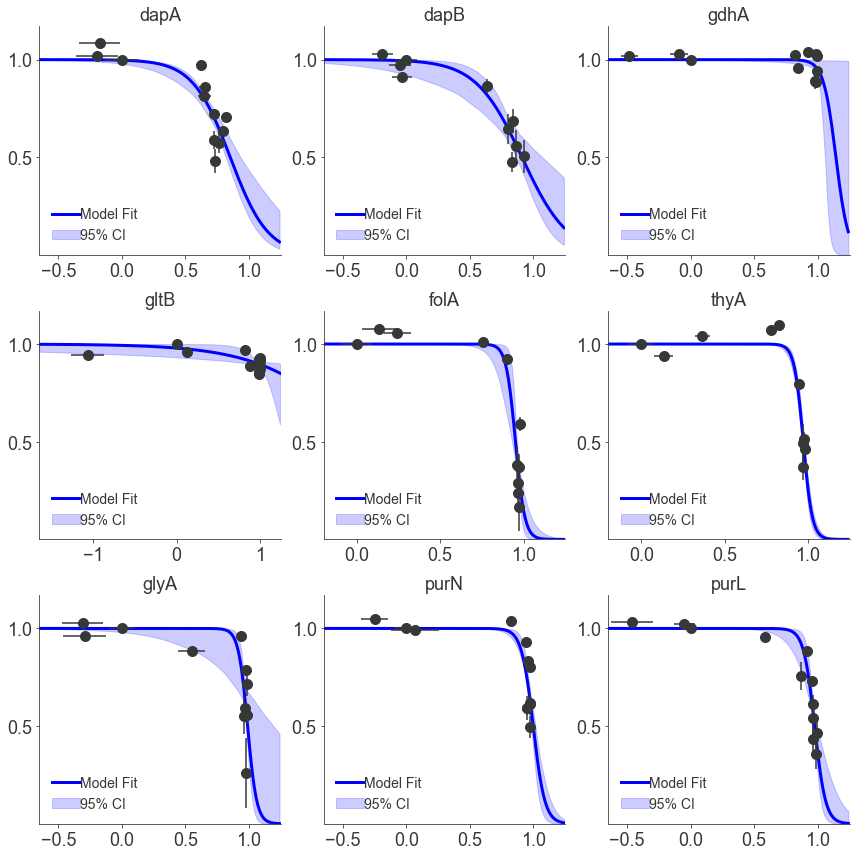

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))        
fitVal_list = {}
for iterator, gene in enumerate(gene_names):
    row, col, fitVal_list[gene], xmean, xerr, ymean, yerr = int(iterator/3), iterator%3, [], [], [], [], []
    for sgRNA in dict_growth_pool:
        if sgRNA.startswith(gene) or sgRNA == 'negC_rand_42':
            xmean.append(qPCR_vals[gene][sgRNA])
            xerr.append(qPCR_sem[gene][sgRNA])
            ymean.append(growth_df_rescale.loc[sgRNA, 'negC_rand_42'])
            yerr.append(sem_df_rescale.loc[sgRNA, 'negC_rand_42'])
    # Pick the best x-axis limit for a given gene
    if gene in ['folA', 'thyA']:
        temp_floor = np.floor(np.min(xmean)-0.00001) + 0.8
    else:
        temp_floor = np.floor(np.min(xmean)-0.00001) + 0.35
    xVals = np.arange(temp_floor, 1.25, 0.01)
    for i in hill_est:
        if i != 'Full Fit':
            fitVal_list[gene].append(growth_rate(xVals, hill_est[i][gene][0], hill_est[i][gene][1]))
    low_q, high_q = [], []
    for i in range(len(xVals)):
        low_q.append(np.quantile([x[i] for x in fitVal_list[gene]], 0.025))
        high_q.append(np.quantile([x[i] for x in fitVal_list[gene]], 0.975))
    fitVals = growth_rate(xVals, hill_est['Full Fit'][gene][0], hill_est['Full Fit'][gene][1])
    ax[row, col].plot(xVals, fitVals, '-b', lw=3, label='Model Fit')
    ax[row, col].fill_between(xVals, low_q, high_q, alpha=0.2, color='b', label='95% CI')
    ax[row, col].legend()
    ax[row, col].errorbar(xmean, ymean, xerr=xerr, yerr=yerr, fmt='o', color='xkcd:dark gray', ms=10)
    ax[row, col].set_xlim(temp_floor, 1.25)
    ax[row, col].set_ylim([0, 1.17])
    ax[row, col].set_yticks([0.5, 1])
    ax[row, col].set_title(gene, fontsize=18)
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig1F_2E-M.pdf')
plt.show()

### Fit coupling constants and calculate predicted growth rates

We fit coupling constants to pairwise expression-growth rate data, then use these coupling constants and single-gene sigmoid parameters to generate predicted growth rates for each CRISPRi perturbation. We also predict growth rates using subsampled pairwise growth rate data as well as a Null model without coupling and a multiplicative model that considers only sgRNA identity and cannot make predictions based on expression changes.

Note: As this code block is repeated 101 times (once for the full model fit, 100 times for bootstrapped replicates), we've saved its output and read it in above. Assuming the same single-gene curves (hill_est) are used as inputs, it will results in the same output as that we have saved.

In [10]:
"""
pair_avals, pair_avals_sub, pair_avals_corners = {}, {}, {}
reg, sub = 10**-1.25, 0.8
for idx in hill_est:
    fit_gene_all, fit_gene_pairs, fit_gene_pairs_sub = subsample_gr(growth_df_rescale, qPCR_vals, hill_est[idx],
                                                                    'spread', sub)
    _, _, corner_grs = subsample_gr(growth_df_rescale, qPCR_vals, hill_est[idx], 'corners')
    pair_avals[idx] = calc_avals(fit_gene_pairs, qPCR_vals, hill_est[idx], reg)
    pair_avals_sub[idx] = calc_avals(fit_gene_pairs_sub, qPCR_vals, hill_est[idx], reg)
    pair_avals_corners[idx] = calc_avals(corner_grs, qPCR_vals, hill_est[idx], reg)
    print(idx)
with open(f'{bootstrap_path}/{date}_pair_avals.pickle', 'wb') as handle:
    pickle.dump(pair_avals, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{bootstrap_path}/{date}_pair_avals_sub.pickle', 'wb') as handle:
    pickle.dump(pair_avals_sub, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{bootstrap_path}/{date}_pair_avals_corners.pickle', 'wb') as handle:
    pickle.dump(pair_avals_corners, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

### Calculate model performance

For all predictions, we two calculate error metrics: AIC and RMSD. AIC accounts for the difference in the number of parameters between models, penalizing those with additional parameters, while RMSD is blind to these differences. We see that the full model outperforms all others, even when accounting for its additional parameters. While the subsampled model's exact error metrics will change between subsampling iterations, we see that it usually outperforms the other models as well, with only slightly diminished accuracy.

We report the model's true RMSD and AIC using our complete fit and estimate 95% confidence intervals for these error metrics using the 100 bootstrapped replicates.

In [11]:
pred_dict, pred_dict_null, rms_dict, rms_dict_sub, rms_dict_null, pair_avals_null, mult_pred = {}, {}, {}, {}, {}, \
                                                                                               {}, {}
# Calculate the number of fit parameters for each model
epi_k = 2*(len(hill_est['Full Fit'])) + 2*len(pair_avals['Full Fit'])
null_k = 2*(len(hill_est['Full Fit']))
mult_k = 0
fit_gene_all, fit_gene_pairs, _ = subsample_gr(growth_df_rescale, qPCR_vals, hill_est[0], 'spread', 0)
boot_rms_epi, boot_rms_sub, boot_rms_mult, boot_rms_null, boot_AIC_epi, boot_AIC_sub, boot_AIC_mult, boot_AIC_null = \
                                                                                        [], [], [], [], [], [], [], []
for gene_pair in pair_avals['Full Fit']:
    mult_pred[gene_pair] = pred_mult_calculate(fit_gene_all[gene_pair])
    pair_avals_null[gene_pair] = np.array([0, 0])
for idx in pair_avals:
    pred_dict[idx] = calc_pair_gr(growth_df_rescale, qPCR_vals, pair_avals[idx], fit_gene_all, hill_est[idx])
    pred_dict_sub = calc_pair_gr(growth_df_rescale, qPCR_vals, pair_avals_sub[idx], fit_gene_all, hill_est[idx])
    pred_dict_null[idx] = calc_pair_gr(growth_df_rescale, qPCR_vals, pair_avals_null, fit_gene_all, hill_est[idx])
    rms_dict[idx], rms_dict_sub[idx], rms_dict_null[idx] = {}, {}, {}
    full_epi_err, full_sub_err, full_mult_err, full_null_err = [], [], [], []
    for gene_pair in pair_avals[idx]:
        expt_genepair = fit_gene_all[gene_pair].values
        pred_mult_genepair = mult_pred[gene_pair].values
        err_mult, err_epi, err_sub, err_null = [], [], [], []
        for j, guide2 in enumerate(list(fit_gene_all[gene_pair].index)):
            if guide2 != 'negC_rand_42':  # Not single-order data
                for k, guide1 in enumerate(list(fit_gene_all[gene_pair].columns)):
                    if guide1 != 'negC_rand_42':  # Not single-order data
                        err_mult.append(expt_genepair[j, k] - pred_mult_genepair[j, k])
                        err_epi.append(expt_genepair[j, k] - pred_dict[idx][gene_pair][j, k])
                        err_sub.append(expt_genepair[j, k] - pred_dict_sub[gene_pair][j, k])
                        err_null.append(expt_genepair[j, k] - pred_dict_null[idx][gene_pair][j, k])
        full_epi_err += err_epi
        full_sub_err += err_sub
        full_mult_err += err_mult
        full_null_err += err_null
        rms_dict[idx][gene_pair] = nanrms(np.array(err_epi))
        rms_dict_sub[idx][gene_pair] = nanrms(np.array(err_sub))
        rms_dict_null[idx][gene_pair] = nanrms(np.array(err_null))
    if idx == 'Full Fit':
        full_epi_rmsd = nanrms(np.array(full_epi_err))
        full_sub_rmsd = nanrms(np.array(full_sub_err))
        full_mult_rmsd = nanrms(np.array(full_mult_err))
        full_null_rmsd = nanrms(np.array(full_null_err))
        full_epi_AIC = 2*epi_k + sum(~np.isnan(full_epi_err))*np.log(np.nanmean([x**2 for x in full_epi_err]))
        full_sub_AIC = 2*epi_k + sum(~np.isnan(full_sub_err))*np.log(np.nanmean([x**2 for x in full_sub_err]))
        full_mult_AIC = 2*mult_k + sum(~np.isnan(full_mult_err))*np.log(np.nanmean([x**2 for x in full_mult_err]))
        full_null_AIC = 2*null_k + sum(~np.isnan(full_null_err))*np.log(np.nanmean([x**2 for x in full_null_err]))
    else:
        boot_rms_epi.append(nanrms(np.array(full_epi_err)))
        boot_rms_sub.append(nanrms(np.array(full_sub_err)))
        boot_rms_mult.append(nanrms(np.array(full_mult_err)))
        boot_rms_null.append(nanrms(np.array(full_null_err)))
        boot_AIC_epi.append(2*epi_k \
                           + sum(~np.isnan(full_epi_err))*np.log(np.nanmean([x**2 for x in full_epi_err])))
        boot_AIC_sub.append(2*epi_k + sum(~np.isnan(full_sub_err))*np.log(np.nanmean([x**2 for x in full_sub_err])))
        boot_AIC_mult.append(2*mult_k \
                          + sum(~np.isnan(full_mult_err))*np.log(np.nanmean([x**2 for x in full_mult_err])))
        boot_AIC_null.append(2*null_k \
                          + sum(~np.isnan(full_null_err))*np.log(np.nanmean([x**2 for x in full_null_err])))
for (title, data, full) in zip(['Epistatic', 'Subsampled', 'Null', 'Bliss'],
                                       [boot_rms_epi, boot_rms_sub, boot_rms_null, boot_rms_mult],
                                       [full_epi_rmsd, full_sub_rmsd, full_null_rmsd, full_mult_rmsd]):
    print(f'{title} model RMSD, [95% CI]: '
          f'{np.round(full, 3)}, [{np.round(np.quantile(data, 0.025), 3)}, {np.round(np.quantile(data, 0.975), 3)}]')
print()
for (title, data, full) in zip(['Epistatic', 'Subsampled', 'Null', 'Bliss'],
                                       [boot_AIC_epi, boot_AIC_sub, boot_AIC_null, boot_AIC_mult],
                                       [full_epi_AIC, full_sub_AIC, full_null_AIC, full_mult_AIC]):
    print(f'{title} model AIC, [95% CI]: '
          f'{np.round(full)}, [{np.round(np.quantile(data, 0.025))}, {np.round(np.quantile(data, 0.975))}]')

Epistatic model RMSD, [95% CI]: 0.123, [0.122, 0.139]
Subsampled model RMSD, [95% CI]: 0.128, [0.125, 0.144]
Null model RMSD, [95% CI]: 0.158, [0.151, 0.173]
Bliss model RMSD, [95% CI]: 0.144, [0.144, 0.144]

Epistatic model AIC, [95% CI]: -15716.0, [-15785.0, -14743.0]
Subsampled model AIC, [95% CI]: -15380.0, [-15580.0, -14508.0]
Null model AIC, [95% CI]: -13958.0, [-14299.0, -13262.0]
Bliss model AIC, [95% CI]: -14698.0, [-14698.0, -14698.0]


### What if we train a model using only the strongest available double-knockdown?

We wanted to compare our experimental approach to a more classical double-knockout approach by calculating gene-gene epistasis using only the strongest double knockdown measurement. This alternative approach would drastically reduce the input data required, but we find that this model's predictions are both (i) highly susceptible to experimental noise (which is why increasing regularization strength always improves performance) and (ii) fail to reproduce intermediate pairwise knockdown dynamics, which is why the model can never outperform even a coupling-insensitive Null model. This illustrates that while we may be able to estimate the sign of epistatic interactions using a simple double knockdown procedure, this is insufficient to predict intermediate double knockdown effects.

### What if we transpose our coupling constant matrix?

Some coupling constant pairs are asymmetrical. Does this asymmetry represent a true difference in how two genes interact, or can two coupling constants be swapped and reproduce the same prediction? We transposed our coupling constant matrix to show that model performance is lost without correctly accounting for coupling constant asymmetry. Note that this transposed model still outperforms the Null model -- this is because many coupling constant pairs are roughly symmetrical, meaning this transposed model captures some epistasis.

In [12]:
transpose_rms_dict, corner_rms_dict, transpose_RMSD, transpose_AIC, corner_RMSD, corner_AIC = {}, {}, [], [], [], []
for i in pair_avals_corners:
    transpose_rms_dict[i], corner_rms_dict[i], temp_corner_err, temp_transpose_err = {}, {}, [], []
    pair_avals_transpose = {gene_pair:pair_avals[i][gene_pair][::-1] for gene_pair in pair_avals[i]}
    pred_dict_corner = calc_pair_gr(growth_df_rescale, qPCR_vals, pair_avals_corners[i], fit_gene_all, hill_est[i])
    pred_dict_transpose = calc_pair_gr(growth_df_rescale, qPCR_vals, pair_avals_transpose, fit_gene_all, hill_est[i])
    for gene_pair in pair_avals_corners[i]:
        gene_corner_err, gene_transpose_err = [], []
        expt_genepair = fit_gene_all[gene_pair].values
        for j, guide2 in enumerate(list(fit_gene_all[gene_pair].index)):
            if guide2 != 'negC_rand_42':  # Not single-order data
                for k, guide1 in enumerate(list(fit_gene_all[gene_pair].columns)):
                    if guide1 != 'negC_rand_42':  # Not single-order data
                        gene_corner_err.append(expt_genepair[j, k] - pred_dict_corner[gene_pair][j, k])
                        gene_transpose_err.append(expt_genepair[j, k] - pred_dict_transpose[gene_pair][j, k])
                        transpose_rms_dict[i][gene_pair] = nanrms(np.array(gene_transpose_err))
                        corner_rms_dict[i][gene_pair] = nanrms(np.array(gene_corner_err))
        temp_corner_err += gene_corner_err
        temp_transpose_err += gene_transpose_err
    if i != 'Full Fit':
        transpose_RMSD.append(nanrms(np.array(temp_transpose_err)))
        transpose_AIC.append(2*epi_k
                       + sum(~np.isnan(temp_transpose_err))*np.log(np.nanmean([x**2 for x in temp_transpose_err])))
        corner_RMSD.append(nanrms(np.array(temp_corner_err)))
        corner_AIC.append(2*epi_k
                    + sum(~np.isnan(temp_corner_err))*np.log(np.nanmean([x**2 for x in temp_corner_err])))
    else:
        full_corner_rmsd = nanrms(np.array(temp_corner_err))
        full_corner_AIC = 2*epi_k \
                        + sum(~np.isnan(temp_corner_err))*np.log(np.nanmean([x**2 for x in temp_corner_err]))
        full_transpose_rmsd = nanrms(np.array(temp_transpose_err))
        full_transpose_AIC = 2*epi_k \
                           + sum(~np.isnan(temp_transpose_err))*np.log(np.nanmean([x**2 for x in temp_transpose_err]))
for (title, data, full) in zip(['Double Knockdown', 'Transposed'], [corner_RMSD, transpose_RMSD],
                               [full_corner_rmsd, full_transpose_rmsd]):
    print(f'{title} model RMSD, [95% CI]: '
          f'{np.round(full, 3)}, [{np.round(np.quantile(data, 0.025), 3)}, {np.round(np.quantile(data, 0.975), 3)}]')
print()
for (title, data, full) in zip(['Double Knockdown', 'Transposed'], [corner_AIC, transpose_AIC],
                               [full_corner_AIC, full_transpose_AIC]):
    print(f'{title} model AIC, [95% CI]: '
          f'{np.round(full)}, [{np.round(np.quantile(data, 0.025))}, {np.round(np.quantile(data, 0.975))}]')

Double Knockdown model RMSD, [95% CI]: 0.194, [0.174, 0.206]
Transposed model RMSD, [95% CI]: 0.137, [0.131, 0.154]

Double Knockdown model AIC, [95% CI]: -12225.0, [-13078.0, -11804.0]
Transposed model AIC, [95% CI]: -14880.0, [-15192.0, -13980.0]


### Plot continuous epistasis model performance against Null model performance for all gene pairs

We plot the prediction RMSD across every gene pair for both the complete continuous epistasis model, the Null model, and a subsampled continuous epistasis model trained on only 20% of the pairwise growth rate data. The continuous epistasis model (trained on all data or subsampled) is equivalent or superior to the Null model for all gene pairs (which is expected), and approaches the limit of experimental reproducibility. Error bars represent the standard deviation of model error across bootstrapped replicates.

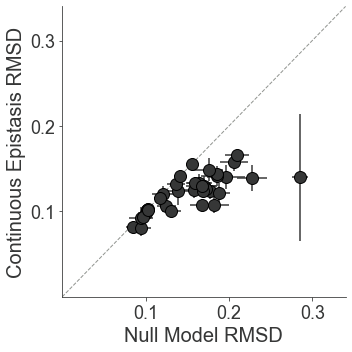

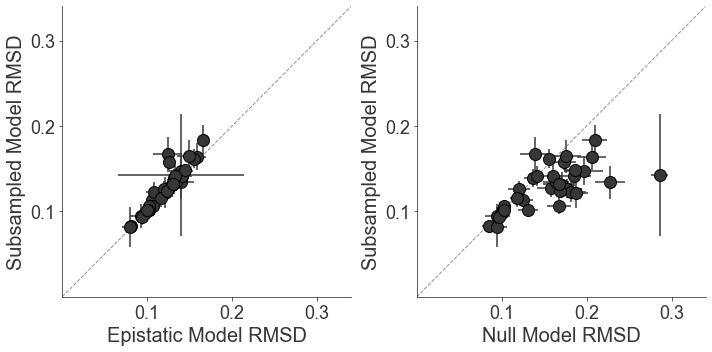

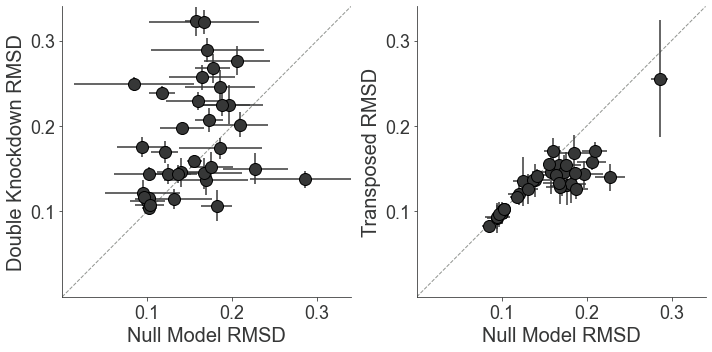

In [13]:
null_err, epi_err, sub_err, transpose_err, corner_err = [], [], [], [], []
for gene_pair in rms_dict['Full Fit']:
    null_err.append(np.std([rms_dict_null[idx][gene_pair] for idx in rms_dict_null]))
    epi_err.append(np.std([rms_dict[idx][gene_pair] for idx in rms_dict]))
    sub_err.append(np.std([rms_dict_sub[idx][gene_pair] for idx in rms_dict_sub]))
    transpose_err.append(np.std([transpose_rms_dict[idx][gene_pair] for idx in transpose_rms_dict]))
    corner_err.append(np.std([corner_rms_dict[idx][gene_pair] for idx in corner_rms_dict]))
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(rms_dict_null['Full Fit'].values(), rms_dict['Full Fit'].values(), xerr=null_err, yerr=epi_err,
               color='xkcd:dark gray', ms=12, fmt='o', mec='k', zorder=1)
ax.set_xlim([0, 0.34])
ax.set_ylim([0, 0.34])
ax.plot([0, 0.34], [0, 0.34], lw=1, ls='--', color='xkcd:gray', zorder=0)
ax.tick_params(axis='both', labelsize=18)
ax.set_xticks([0.1, 0.2, 0.3])
ax.set_yticks([0.1, 0.2, 0.3])
ax.set_xlabel(f'Null Model RMSD', fontsize=20)
ax.set_ylabel(f'Continuous Epistasis RMSD', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig4G.pdf')
plt.show() 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].errorbar(rms_dict['Full Fit'].values(), rms_dict_sub['Full Fit'].values(), xerr=epi_err, yerr=sub_err,
               color='xkcd:dark gray', ms=12, fmt='o', mec='k', zorder=1)
ax[1].errorbar(rms_dict_null['Full Fit'].values(), rms_dict_sub['Full Fit'].values(), xerr=null_err, yerr=sub_err,
               color='xkcd:dark gray', ms=12, fmt='o', mec='k', zorder=1)
for i, (xlabel, ylabel) in enumerate(zip(['Epistatic', 'Null'], ['Subsampled', 'Subsampled'])):
    ax[i].set_xlim([0, 0.34])
    ax[i].set_ylim([0, 0.34])
    ax[i].plot([0, 0.34], [0, 0.34], lw=1, ls='--', color='xkcd:gray', zorder=0)
    ax[i].tick_params(axis='both', labelsize=18)
    ax[i].set_xticks([0.1, 0.2, 0.3])
    ax[i].set_yticks([0.1, 0.2, 0.3])
    ax[i].set_xlabel(f'{xlabel} Model RMSD', fontsize=20)
    ax[i].set_ylabel(f'{ylabel} Model RMSD', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS5.pdf')
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].errorbar(rms_dict_null['Full Fit'].values(), corner_rms_dict['Full Fit'].values(), yerr=null_err,
               xerr=corner_err, color='xkcd:dark gray', ms=12, fmt='o', mec='k', zorder=1)
ax[1].errorbar(rms_dict_null['Full Fit'].values(), transpose_rms_dict['Full Fit'].values(), xerr=null_err,
               yerr=transpose_err, color='xkcd:dark gray', ms=12, fmt='o', mec='k', zorder=1)
for i, (xlabel, ylabel) in enumerate(zip(['Null Model', 'Null Model'],
                                         ['Double Knockdown', 'Transposed'])):
    ax[i].set_xlim([0, 0.34])
    ax[i].set_ylim([0, 0.34])
    ax[i].plot([0, 0.34], [0, 0.34], lw=1, ls='--', color='xkcd:gray', zorder=0)
    ax[i].tick_params(axis='both', labelsize=18)
    ax[i].set_xticks([0.1, 0.2, 0.3])
    ax[i].set_yticks([0.1, 0.2, 0.3])
    ax[i].set_xlabel(f'{xlabel} RMSD', fontsize=20)
    ax[i].set_ylabel(f'{ylabel} RMSD', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS3G-H.pdf')
plt.show()

### Visualize epistasis from the continuous epistasis model and a simple Bliss epistasis

Coupling values derived from the continuous epistasis model are shown. In addition, Bliss epistasis is calculated for the most severe knockdowns (this approximates a classical knockout study, where epistasis is calculated only at this severe perturbation level). We see that gene-gene epistasis may be most prevalent at these extreme levels, potentially due to a decrease in the signal-to-noise ratio we observe at these low growth rates. When considering the entire expression-growth rate landscape, which we approximate with numerous titrated CRISPRi measurements, gene-gene epistasis is fairly rare.

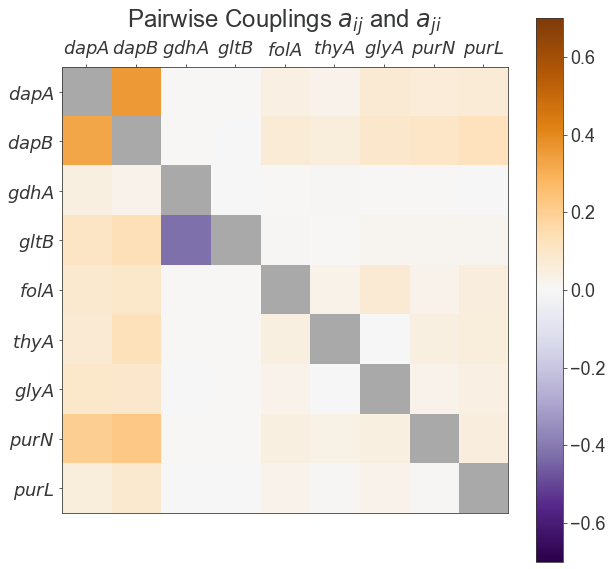

In [14]:
avals = pd.DataFrame(np.zeros((len(gene_names), len(gene_names))), gene_names, gene_names)
for gene_pair in pair_avals[0]:
    avals.loc[gene_pair[0], gene_pair[1]] = pair_avals['Full Fit'][gene_pair][0]
    avals.loc[gene_pair[1], gene_pair[0]] = pair_avals['Full Fit'][gene_pair][1]
for gene in gene_names:
    avals.loc[gene, gene] = np.nan
fig, ax = plt.subplots(figsize=(10, 10))
ax, cb = heat_map(avals, ax=ax, xticks=[f'$\it{x}$' for x in gene_names], yticks=[f'$\it{x}$' for x in gene_names],
                  vmin=-0.7, vmax=0.7, cmap='PuOr_r')
plt.colorbar(cb)
ax.set_title('Pairwise Couplings $a_{ij}$ and $a_{ji}$', fontsize=24)
plt.savefig(f'{figure_path}/Fig4H.pdf')
plt.show()

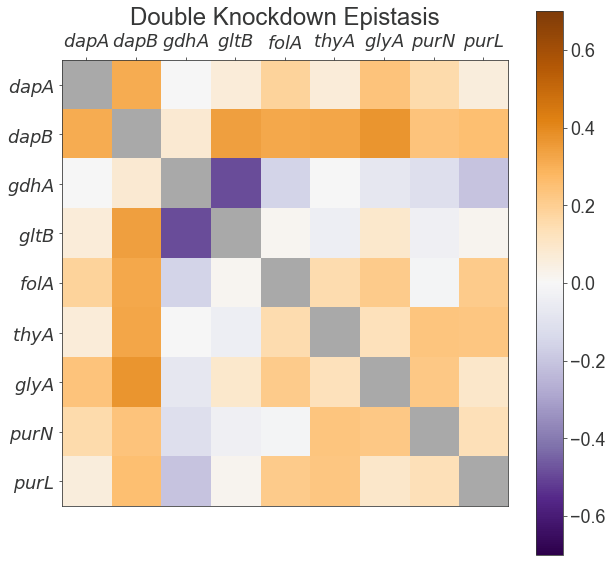

In [15]:
aval_matrix = pd.DataFrame(np.zeros((len(gene_names), len(gene_names))), gene_names, gene_names)
for gene_pair, data in fit_gene_all.items():
    last_row, last_col = data.index[-1], data.columns[-1]
    if ~np.isnan(data.loc[last_row, last_col]):
        aval_matrix.loc[gene_pair[0], gene_pair[1]] = data.loc[last_row, last_col] \
                                            - data.loc['negC_rand_42', last_col]*data.loc[last_row, 'negC_rand_42']
        aval_matrix.loc[gene_pair[1], gene_pair[0]] = data.loc[last_row, last_col] \
                                            - data.loc['negC_rand_42', last_col]*data.loc[last_row, 'negC_rand_42']
    else:  # Take average of epistasis from adjacent points
        second_last_row, second_last_col = data.index[-2], data.columns[-2]
        point1 = data.loc[second_last_row, last_col] - data.loc['negC_rand_42', last_col] \
                                                     * data.loc[second_last_row, 'negC_rand_42']
        point2 = data.loc[last_row, second_last_col] - data.loc['negC_rand_42', second_last_col] \
                                                     * data.loc[last_row, 'negC_rand_42']
        aval_matrix.loc[gene_pair[0], gene_pair[1]] = np.mean([point1, point2])
        aval_matrix.loc[gene_pair[1], gene_pair[0]] = np.mean([point1, point2])
for gene in gene_names:
    aval_matrix.loc[gene, gene] = np.nan
fig, ax = plt.subplots(figsize=(10, 10))
ax, cb = heat_map(aval_matrix, ax=ax, xticks=[f'$\it{x}$' for x in gene_names],
                  yticks=[f'$\it{x}$' for x in gene_names], vmin=-0.7, vmax=0.7)
plt.title('Double Knockdown Epistasis', fontsize=24)
plt.colorbar(cb)
plt.savefig(f'{figure_path}/Fig4I.pdf')
plt.show()

### Visualize pairwise expression-growth rate predictions for certain gene pairs

Below we visualize experimental and predicted growth rates for select genes pairs showing strong positive ($dapA$/$purN$, $dapA$/$dapB$), strong negative ($gdhA$/$gltB$), and no strong ($purN$/$purL$) epistasis. For gene pairs showing strong epistasis, the Continuous Epistasis model drastically outperforms the Null model (quantified by RMSD). For the final gene pair with minimal epistasis, the models perform comparably.

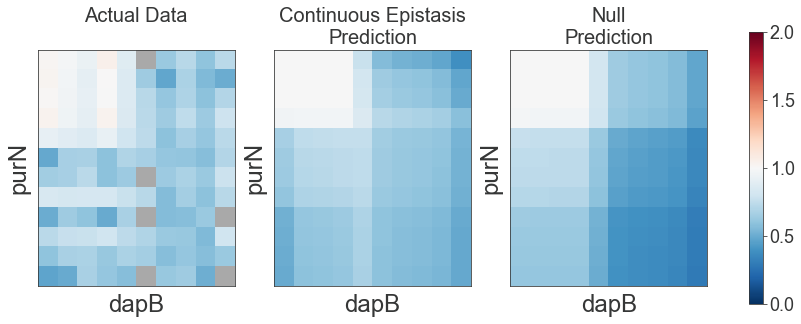

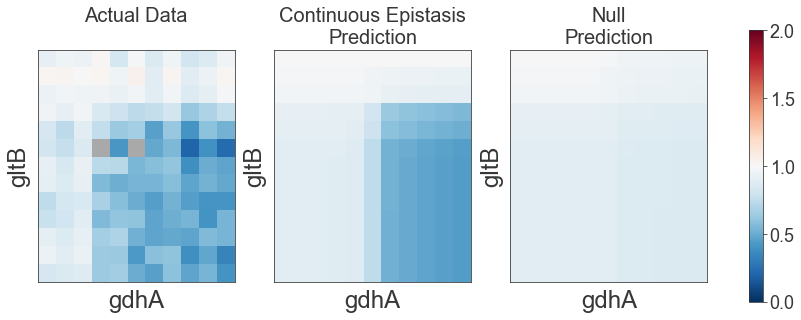

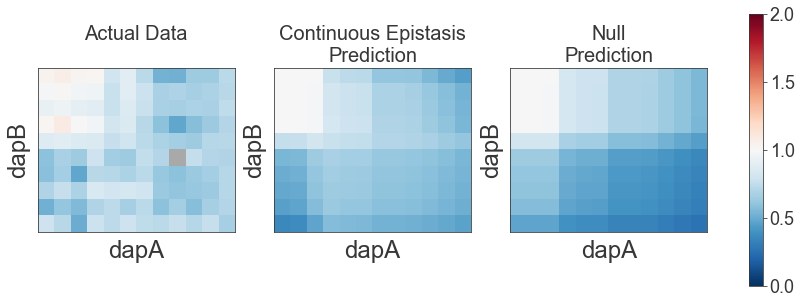

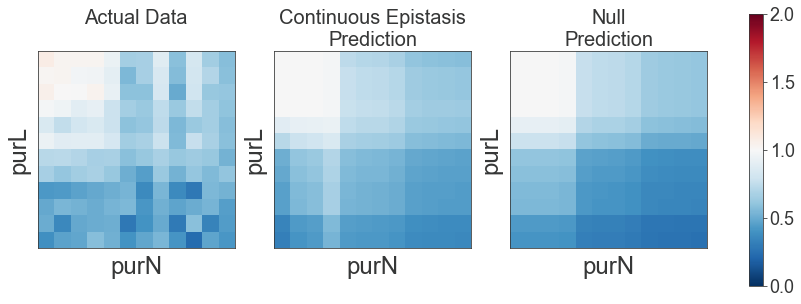

In [16]:
fig_numbers = ['4A-C', '4D-F', 'S3A-C', 'S3D-F']
for i, gene_pair in enumerate([('dapB', 'purN'), ('gdhA', 'gltB'), ('dapA', 'dapB'), ('purN', 'purL')]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _, cb = heat_map(fit_gene_all[gene_pair], xlabel=gene_pair[0], ylabel=gene_pair[1], cmap='RdBu_r', ax=ax[0])
    heat_map(pred_dict['Full Fit'][gene_pair], xlabel=gene_pair[0], ylabel=gene_pair[1], cmap='RdBu_r', ax=ax[1])
    heat_map(pred_dict_null['Full Fit'][gene_pair], xlabel=gene_pair[0], ylabel=gene_pair[1], cmap='RdBu_r', ax=ax[2])
    for j, title in enumerate(['Actual Data\n', 'Continuous Epistasis\nPrediction', 'Null\nPrediction']):
        ax[j].set_title(title, fontsize=20)
    plt.colorbar(cb, ax=ax)
    plt.savefig(f'{figure_path}/Fig{fig_numbers[i]}.pdf')
    plt.show()

### Visualize example gene-expression landscapes from endpoint or continuous data

Using endpoint (wildtype, single-knockdown, and double-knockdown) measurements alone, one can interpolate a continuous, pairwise expression growth rate landscape. This landscape, however, can be drastically different from reality due to nonlinearities and coupling. The $dapA$/$purN$ gene pair represents a strong example of this, and we plot the varying landscapes inferred using both a discretized and endpoint approach.

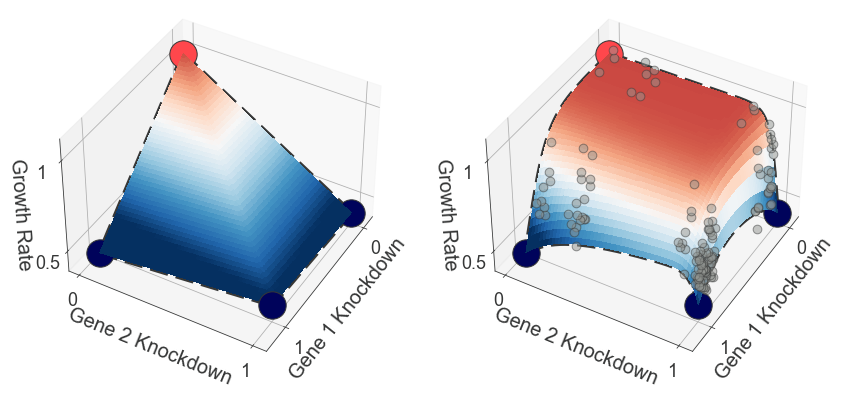

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={"projection": "3d"})
X = np.arange(min(qPCR_vals['dapA'].values())-0.1, max(qPCR_vals['dapA'].values())+0.01,
              (max(qPCR_vals['dapA'].values())+0.01 - (min(qPCR_vals['dapA'].values())-0.1))/200)
Y = np.arange(min(qPCR_vals['purN'].values())-0.1, max(qPCR_vals['purN'].values())+0.01,
              (max(qPCR_vals['purN'].values())+0.01 - (min(qPCR_vals['purN'].values())-0.1))/200)
Z_exp, Z_lin = np.full((len(Y), len(X)), np.nan), np.full((len(Y), len(X)), np.nan)
# Extract experimentally-determined pairwise growth rate data
for i, per in enumerate(Y):
    Z_exp[i, :] = pairGrowthRates(pair_avals['Full Fit'][('dapA', 'purN')], [per], X, hill_est['Full Fit']['purN'],
                              hill_est['Full Fit']['dapA'])[0]
X, Y = np.meshgrid(X, Y)
# Linearly interpolate pairwise expression growth rate data from endpoit measurements
for i, _ in enumerate(Z_exp):
    for j, _ in enumerate(Z_exp[i, :]):
        if i > j:
            Z_lin[i, j] = Z_exp[0, 0]+(Y[i, j]-Y[0, 0])/(Y[-1, 0]-Y[0, 0])*(Z_exp[-1, 0]-Z_exp[0, 0]) \
                    + (X[i, j]-X[-1, 0])/(X[-1, -1]-X[-1, 0])*(Z_exp[-1, -1]-Z_exp[-1, 0])
        else:
            Z_lin[i, j] = Z_exp[0, 0]+(X[i, j]-X[0, 0])/(X[0, -1]-X[0, 0])*(Z_exp[0, -1]-Z_exp[0, 0]) \
                    + (Y[i, j]-Y[0, -1])/(Y[-1, -1]-Y[0, -1])*(Z_exp[-1, -1]-Z_exp[0, -1])
x, y, z_exp, z_lin= [X[i, i] for i, _ in enumerate(X)], [Y[i, i] for i, _ in enumerate(Y)], \
             [Z_exp[i, i] for i, _ in enumerate(Z_exp)], [Z_lin[i, i] for i, _ in enumerate(Z_lin)]
# Plot linearly-interpolated surface
surf = ax[0].plot_surface(X, Y, Z_lin, cmap='RdBu_r', linewidth=0, antialiased=False, vmin=0.5, vmax=1.1, zorder=0)
ax[0].plot([X[0, 0], X[-1, 0]], [Y[0, 0], Y[-1, 0]], [Z_exp[0, 0], Z_exp[-1, 0]], ls='--', lw=5,
           color='xkcd:dark gray')
ax[0].plot([X[0, 0], X[0, -1]], [Y[0, 0], Y[0, -1]], [Z_exp[0, 0], Z_exp[0, -1]], ls='--', lw=5,
           color='xkcd:dark gray')
ax[0].plot([X[-1, 0], X[-1, -1]], [Y[-1, 0], Y[-1, -1]], [Z_exp[-1, 0], Z_exp[-1, -1]], ls='--', lw=5,
           color='xkcd:dark gray')
ax[0].plot([X[0, -1], X[-1, -1]], [Y[0, -1], Y[-1, -1]], [Z_exp[0, -1], Z_exp[-1, -1]], ls='--', lw=5,
           color='xkcd:dark gray')
x1, y1, z_exp, z_lin= [X[i, i] for i, _ in enumerate(X)], [Y[i, i] for i, _ in enumerate(Y)], \
             [Z_exp[i, i] for i, _ in enumerate(Z_exp)], [Z_lin[i, i] for i, _ in enumerate(Z_lin)]
ax[0].plot(x, y, z_lin, lw=5, ls='--', color='xkcd:dark gray')
# Plot continually-fit surface
surf = ax[1].plot_surface(X, Y, Z_exp, cmap='RdBu_r', linewidth=0, antialiased=False, vmin=0.5, vmax=1.1, zorder=0)
ax[1].plot(X[0, :], Y[0, :], Z_exp[0, :], lw=5, ls='--', color='xkcd:dark gray')
ax[1].plot(X[:, 0], Y[:, 0], Z_exp[:, 0], lw=5, ls='--', color='xkcd:dark gray')
ax[1].plot(X[-1, :], Y[-1, :], Z_exp[-1, :], lw=5, ls='--', color='xkcd:dark gray')
ax[1].plot(X[:, -1], Y[:, -1], Z_exp[:, -1], lw=5, ls='--', color='xkcd:dark gray')
x2, y2, z2 = [X[i, i] for i, _ in enumerate(X)], [Y[i, i] for i, _ in enumerate(Y)], \
             [Z_exp[i, i] for i, _ in enumerate(Z_exp)]
ax[1].plot(x, y, z_exp, lw=5, ls='--', color='xkcd:dark gray')
x_ind, y_ind, z_ind = [], [], []
for sgRNA1, val1 in qPCR_vals['dapA'].items():
    for sgRNA2, val2 in qPCR_vals['purN'].items():
        x_ind.append(val1)
        y_ind.append(val2)
        z_ind.append(fit_gene_all[('dapA', 'purN')].loc[sgRNA2, sgRNA1])
ax[1].scatter(xs=x_ind, ys=y_ind, zs=z_ind, color='xkcd:gray', ec='xkcd:dark gray', s=75, depthshade=False, alpha=0.5)
for i in [0, 1]:
    ax[i].scatter(X[0, 0], Y[0, 0], Z_exp[0, 0], s=750, ec='xkcd:dark gray', depthshade=False, color='xkcd:light red')
    ax[i].scatter(X[0, -1], Y[0, -1], Z_exp[0, -1], s=750, ec='xkcd:dark gray', depthshade=False,
                  color='xkcd:dark blue')
    ax[i].scatter(X[-1, 0], Y[-1, 0], Z_exp[-1, 0], s=750, ec='xkcd:dark gray', depthshade=False,
                  color='xkcd:dark blue')
    ax[i].scatter(X[-1, -1], Y[-1, -1], Z_exp[-1, -1], s=750, ec='xkcd:dark gray', depthshade=False,
                  color='xkcd:dark blue')
    ax[i].azim = 30
    ax[i].elev = 40
    ax[i].set_xlabel('Gene 1 Knockdown', fontsize=20)
    ax[i].set_ylabel('Gene 2 Knockdown', fontsize=20)
    ax[i].set_zlabel('Growth Rate', fontsize=20)
    ax[i].set_xticks([X[0, 0], X[-1, -1]])
    ax[i].set_xticklabels(['0', '1'])
    ax[i].set_yticks([Y[0, 0], Y[-1, -1]])
    ax[i].set_yticklabels(['0', '1'])
    ax[i].set_zticks([Z_exp[0, 0], 0.5])
    ax[i].set_zticklabels(['1', '0.5'])
    ax[i].set_xlim([-0.4, 1.05])
    ax[i].set_ylim([-0.4, 1.05])
    ax[i].set_zlim([0.4, 1.1])
plt.savefig(f'{figure_path}/Fig1A-B.pdf')
plt.show()

## Subsampling Strategies

The primary subsampling procedure used is Library Subsampling, where pairwise growth rate measurements are randomly selected from the entire pairwise landscape. This is akin to bottlenecking a large-scale pairwise library, and may result in some gene pairs having comparably more or less data than other pairs. Another tactic, named Pairwise Subsampling, subsamples each set of pairwise growth rate measurements (such as the $dapA$/$purN$ pair) independently. Finally, sgRNA Subsampling removes entire sgRNAs from the starting library, simulating an experiment with a smaller starting oligo pool. All strategies perform comparably, with a slight preference against the sgRNA Subsampling strategy.

In [18]:
with open(f'{optimization_path}/230215_subsampling_examples.pickle', 'rb') as handle:
    subsampling_grs = pickle.load(handle)

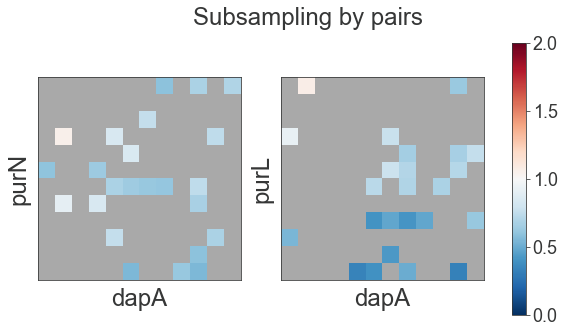

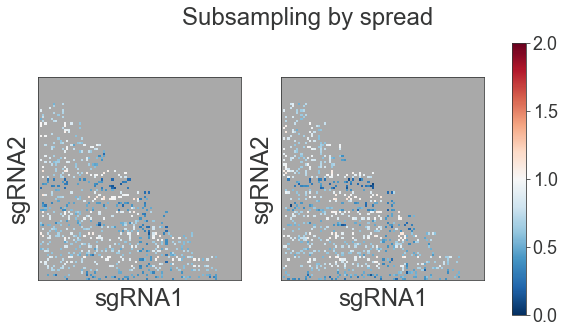

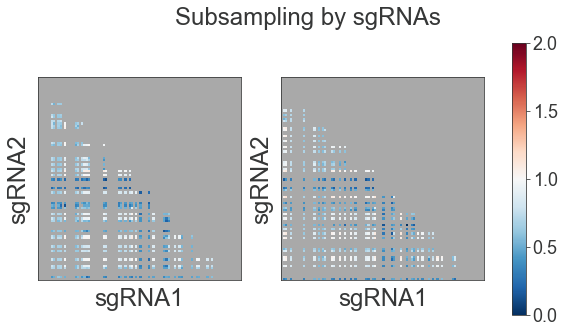

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, gene_pair in enumerate([('dapA', 'purN'), ('dapA', 'purL')]):
    ax[i], cb = heat_map(subsampling_grs['pairs'][i][gene_pair], xlabel=gene_pair[0], ylabel=gene_pair[1],
                         cmap='RdBu_r', ax=ax[i])
plt.colorbar(cb, ax=ax)
plt.suptitle(f'Subsampling by pairs', fontsize=24)
plt.savefig(f'{figure_path}/FigS4B.pdf')
plt.show()
figure_list = ['S4A', 'S4C']
for j, strategy in enumerate(['spread', 'sgRNAs']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i in [0, 1]:
        temp_subsample = pd.DataFrame(np.full((np.shape(growth_df_rescale)), np.nan), index=growth_df_rescale.index,
                                  columns=growth_df_rescale.columns)
        for gene_pair in subsampling_grs[strategy][i]:
            for sgRNA1 in subsampling_grs[strategy][i][gene_pair].index:
                for sgRNA2 in subsampling_grs[strategy][i][gene_pair].columns:
                    temp_subsample.loc[sgRNA1, sgRNA2] = subsampling_grs[strategy][i][gene_pair].loc[sgRNA1, sgRNA2]
        ax[i], cb = heat_map(temp_subsample, cmap='RdBu_r', xlabel='sgRNA1', ylabel='sgRNA2', ax=ax[i])
    plt.colorbar(cb, ax=ax)
    plt.suptitle(f'Subsampling by {strategy}', fontsize=24)
    plt.savefig(f'{figure_path}/Fig{figure_list[j]}.pdf')
    plt.show()

### Import subsampling and regularization optimization data and visualize results

We optimized subsampling and regularization parameters by repeating the subsampling procedure 100 times, with many different internal parameters. This code should be run on a computing cluster if it is to be repeated. We have saved the results of our repeated iterations and summarize results below. The code used to generate these files is below in two commented out cells (labeled Subsampling optimization and Regularization optimization). As these code blocks require random subsampling, future iterations will not produce exactly the same output files (though the error metrics, averaged over 100 iterations, will stay within a narrow range).

In [20]:
with open(f'{optimization_path}/230303_sub_rmsd_pairs.pickle', 'rb') as handle:
    sub_rmsd_pairs = pickle.load(handle)
with open(f'{optimization_path}/230303_sub_rmsd_spread.pickle', 'rb') as handle:
    sub_rmsd_spread = pickle.load(handle)
with open(f'{optimization_path}/230303_sub_rmsd_sgRNAs.pickle', 'rb') as handle:
    sub_rmsd_sgRNAs = pickle.load(handle)
with open(f'{optimization_path}/230303_cross_valid_rmsd.pickle', 'rb') as handle:
    cross_valid_rmsd = pickle.load(handle)

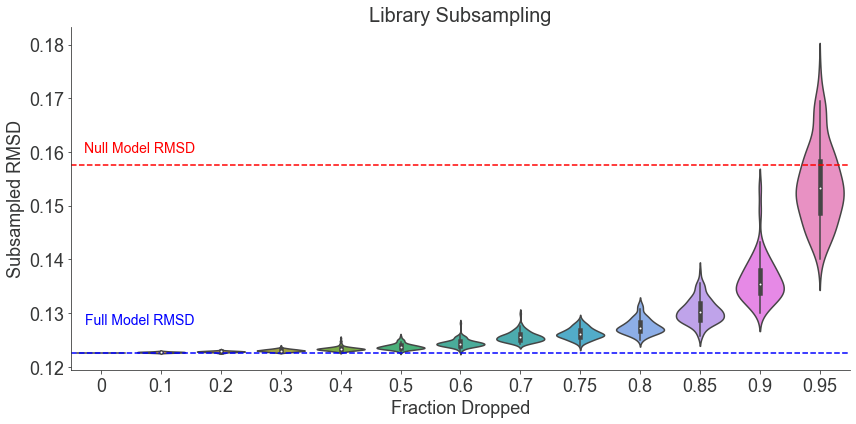

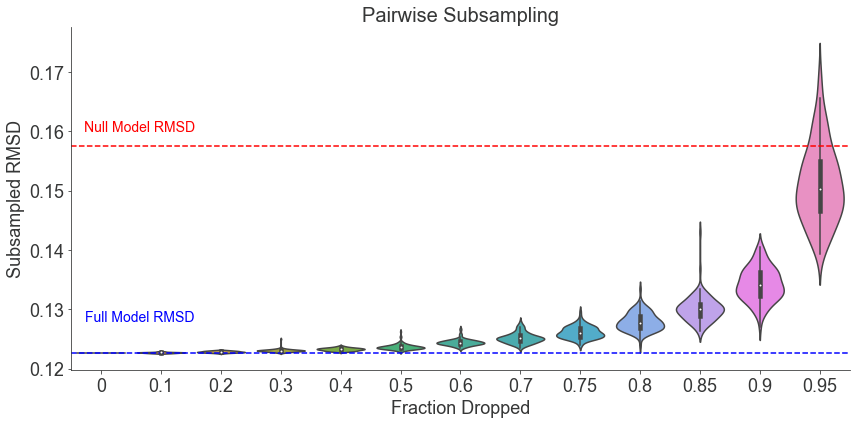

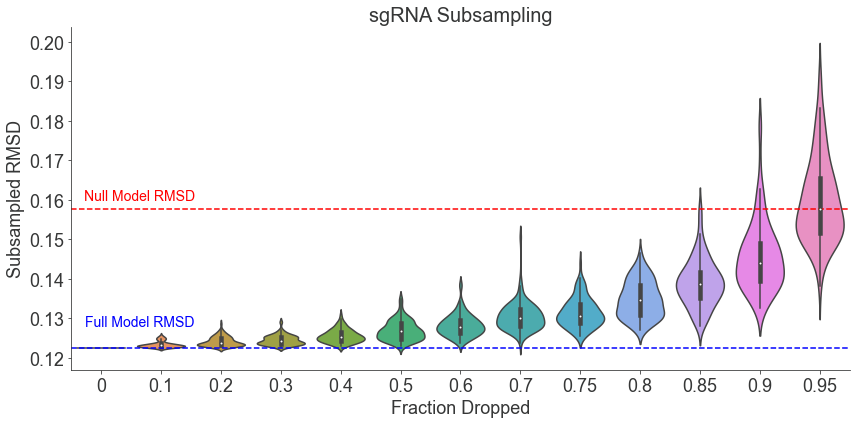

In [21]:
figure_list = ['S4D', 'S4E', 'S4F']
for i, (sub_rmsd, title) in enumerate(zip([sub_rmsd_spread, sub_rmsd_pairs, sub_rmsd_sgRNAs],
                                       ['Library Subsampling', 'Pairwise Subsampling', 'sgRNA Subsampling'])):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    sns.violinplot(data=list(np.array(x) for x in sub_rmsd.values()), scale='width', ax=ax)
    ax.set_xticks(range(len(list(sub_rmsd.keys()))))
    ax.set_xticklabels(list(sub_rmsd.keys()))
    ax.axhline(full_null_rmsd, ls='--', color='r')
    ax.axhline(full_epi_rmsd, ls='--', color='b')
    ax.set_ylabel('Subsampled RMSD', fontsize=18)
    ax.set_xlabel('Fraction Dropped', fontsize=18)
    ax.text(0.65, 0.128, 'Full Model RMSD', horizontalalignment='center', fontsize=14, color='b')
    ax.text(0.65, 0.16, 'Null Model RMSD', horizontalalignment='center', fontsize=14, color='r')
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(f'{figure_path}/Fig{figure_list[i]}.pdf')
    plt.show()

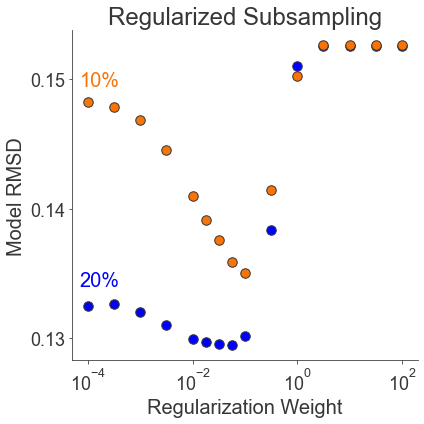

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
for i, sub in enumerate(cross_valid_rmsd):
    temp_rmsd_list = []
    for reg in cross_valid_rmsd[sub][0]:
        xVals = []
        for j in cross_valid_rmsd[sub]:
            xVals += list(cross_valid_rmsd[sub][j][reg].values())
        temp_rmsd_list.append(np.mean(xVals))
    if sub == 0.8:
        ax.scatter(list(cross_valid_rmsd[sub][0]), temp_rmsd_list, s=90, color=['b', 'xkcd:orange'][i],
                   edgecolor='xkcd:dark gray', label='20%')
    elif sub == 0.9:
        ax.scatter(list(cross_valid_rmsd[sub][0]), temp_rmsd_list, s=90, color=['b', 'xkcd:orange'][i],
               edgecolor='xkcd:dark gray', label='10%')
    else:
        ax.scatter(list(cross_valid_rmsd[sub][0]), temp_rmsd_list, s=90, color=['b', 'xkcd:orange'][i],
               edgecolor='xkcd:dark gray', label='{np.round((1-sub)*100, 2)}% Subsampling')
ax.set_xscale('log')
ax.set_xlabel('Regularization Weight', fontsize=20)
ax.set_ylabel('Model RMSD', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
ax.set_title('Regularized Subsampling', fontsize=24)
ax.text(10**-4*0.7, 0.1495, '10%', color='xkcd:orange', fontsize=20)
ax.text(10**-4*0.7, 0.134, '20%', color='b', fontsize=20)
ax.set_yticks([0.13, 0.14, 0.15])
ax.set_xticks([10**-4, 10**-2, 10**0, 10**2])
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS2.pdf')
plt.show()

### Subsampling optimization

This code should only be run on a computing cluster and not locally. The commented out code below was used to generate the subsampling optimization files imported and plotted above.

In [23]:
"""
num_its, reg, sub_list = 100, 10**-1.25, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
sub_rmsd_pairs, sub_rmsd_spread, sub_rmsd_sgRNAs = {}, {}, {}
for sub in sub_list:
    print(f'\nSubsampling: {np.round((1-sub)*100, 2)}')
    sub_rmsd_pairs[sub], sub_rmsd_spread[sub], sub_rmsd_sgRNAs[sub] = [], [], []
    for i in range(num_its):
        print(f'{i}, ', end='')
        _, _, fit_gene_pairs_sub_pairs = subsample_gr(growth_df_rescale, qPCR_vals, hill_est['Full Fit'], 'pairs',
                                                      sub)
        _, _, fit_gene_pairs_sub_spread = subsample_gr(growth_df_rescale, qPCR_vals, hill_est['Full Fit'], 'spread',
                                                       sub)
        _, _, fit_gene_pairs_sub_sgRNAs = subsample_gr(growth_df_rescale, qPCR_vals, hill_est['Full Fit'], 'sgRNAs',
                                                       sub)
        sub_avals_pairs = calc_avals(fit_gene_pairs_sub_pairs, qPCR_vals, hill_est['Full Fit'], reg)
        sub_avals_spread = calc_avals(fit_gene_pairs_sub_spread, qPCR_vals, hill_est['Full Fit'], reg)
        sub_avals_sgRNAs = calc_avals(fit_gene_pairs_sub_sgRNAs, qPCR_vals, hill_est['Full Fit'], reg)
        full_err_pairs, full_err_spread, full_err_sgRNAs = [], [], []
        for gene_pair in sub_avals_pairs:
            expt_genepair = fit_gene_all[gene_pair].values
            temp_dict_pairs, temp_dict_spread, temp_dict_sgRNAs = {}, {}, {}
            temp_dict_pairs[gene_pair] = sub_avals_pairs[gene_pair]
            temp_dict_spread[gene_pair] = sub_avals_spread[gene_pair]
            temp_dict_sgRNAs[gene_pair] = sub_avals_sgRNAs[gene_pair]
            temp_pred_pairs = calc_pair_gr(growth_df_rescale, qPCR_vals, temp_dict_pairs, fit_gene_all,
                                           hill_est['Full Fit'])
            temp_pred_spread = calc_pair_gr(growth_df_rescale, qPCR_vals, temp_dict_spread, fit_gene_all, 
                                        hill_est['Full Fit'])
            temp_pred_sgRNAs = calc_pair_gr(growth_df_rescale, qPCR_vals, temp_dict_sgRNAs, fit_gene_all,
                                            hill_est['Full Fit'])
            for j, guide2 in enumerate(list(fit_gene_all[gene_pair].index)):
                for k, guide1 in enumerate(list(fit_gene_all[gene_pair].columns)):
                    if guide1 != 'negC_rand_42' and guide2 != 'negC_rand_42':
                        full_err_pairs.append(expt_genepair[j, k] - temp_pred_pairs[gene_pair][j, k])
                        full_err_spread.append(expt_genepair[j, k] - temp_pred_spread[gene_pair][j, k])
                        full_err_sgRNAs.append(expt_genepair[j, k] - temp_pred_sgRNAs[gene_pair][j, k])
        sub_rmsd_pairs[sub].append(nanrms(np.array(full_err_pairs)))
        sub_rmsd_spread[sub].append(nanrms(np.array(full_err_spread)))
        sub_rmsd_sgRNAs[sub].append(nanrms(np.array(full_err_sgRNAs)))
        if sub == 0:  # Don't need to repeat, since not removing data
            break
with open(f"{optimization_path}/{date}_sub_rmsd_pairs.pickle", 'wb') as handle:
    pickle.dump(sub_rmsd_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f"{optimization_path}/{date}_sub_rmsd_spread.pickle", 'wb') as handle:
    pickle.dump(sub_rmsd_spread, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f"{optimization_path}/{date}_sub_rmsd_sgRNAs.pickle", 'wb') as handle:
    pickle.dump(sub_rmsd_sgRNAs, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

### Regularization optimization

This code should only be run on a computing cluster and not locally. The commented out code below was used to generate the regularization optimization files imported and plotted above.

In [24]:
"""
num_its, sub_list = 100, [0.8, 0.9]
reg_list = [10**-4, 10**-3.5, 10**-3, 10**-2.5, 10**-2, 10**-1.75, 10**-1.5, 10**-1.25, 10**-1, 10**-0.5, 10**0,
            10**0.5, 10**1, 10**1.5, 10**2]
cross_valid_rmsd = {}
for sub in sub_list:
    print(f'Subsampling: {np.round((1-sub)*100, 2)}')
    cross_valid_rmsd[sub] = {}
    for i in range(num_its):
        print(i)
        cross_valid_rmsd[sub][i] = {}
        fit_gene_all, fit_gene_pairs, fit_gene_pairs_sub = subsample_gr(growth_df_rescale, qPCR_vals,
                                                                        hill_est['Full Fit'], 'spread', sub)
        for reg in reg_list:
            reg_pair_avals_sub = calc_avals(fit_gene_pairs_sub, qPCR_vals, hill_est['Full Fit'], reg)
            pred_dict_sub = calc_pair_gr(growth_df_rescale, qPCR_vals, reg_pair_avals_sub, fit_gene_all,
                                         hill_est['Full Fit'])
            cross_valid_rmsd[sub][i][reg] = cross_validate(fit_gene_pairs, fit_gene_pairs_sub, pred_dict_sub)
with open(f"{optimization_path}/{date}_cross_valid_rmsd.pickle", 'wb') as handle:
    pickle.dump(cross_valid_rmsd, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

### Generate tables and export data

In [25]:
table_s2 = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Table S2', index_col='Unnamed: 0')
for i in table_s2.index:
    if table_s2.loc[i, 'Gene'] == 'Pathway Experiment':
        break
    gene = table_s2.loc[i, 'Gene']
    gene_R0 = [hill_est[boot][gene][0] for boot in hill_est if boot != 'Full Fit']
    gene_steepness = [hill_est[boot][gene][1] for boot in hill_est if boot != 'Full Fit']
    table_s2.loc[i] = [gene, np.round(hill_est['Full Fit'][gene][0], 3),
                       f'[{np.round(np.quantile(gene_R0, 0.025), 3)}, {np.round(np.quantile(gene_R0, 0.975), 3)}]',
                       np.round(hill_est['Full Fit'][gene][1], 3),
            f'[{np.round(np.quantile(gene_steepness, 0.025), 3)}, {np.round(np.quantile(gene_steepness, 0.975), 3)}]']
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_s2.to_excel(writer, sheet_name='Table S2')
table_s3 = pd.DataFrame(np.full(((int(len(gene_names)*(len(gene_names)-1)/2)), 10), np.nan),
                        columns=['Gene 1', 'Gene 2', 'aij', 'aij 95% CI', 'aji', 'aji 95% CI', 'Model RMSD', 
                                 'Model RMSD 95% CI', 'Null RMSD', 'Null RMSD 95% CI'])
for i, gene_pair in enumerate(pair_avals['Full Fit']):
    boot_aij = [pair_avals[boot][gene_pair][0] for boot in pair_avals if boot != 'Full Fit']
    boot_aji = [pair_avals[boot][gene_pair][1] for boot in pair_avals if boot != 'Full Fit']
    model_rmsd = [rms_dict[boot][gene_pair] for boot in rms_dict if boot != 'Full Fit']
    null_rmsd = [rms_dict_null[boot][gene_pair] for boot in rms_dict_null if boot != 'Full Fit']
    table_s3.loc[i] = [gene_pair[0], gene_pair[1], np.round(pair_avals['Full Fit'][gene_pair][0], 3),
                       f'[{np.round(np.quantile(boot_aij, 0.025), 3)}, {np.round(np.quantile(boot_aij, 0.975), 3)}]',
                       np.round(pair_avals['Full Fit'][gene_pair][1], 3),
                       f'[{np.round(np.quantile(boot_aji, 0.025), 3)}, {np.round(np.quantile(boot_aji, 0.975), 3)}]',
                       np.round(rms_dict['Full Fit'][gene_pair], 3),
                    f'[{np.round(np.quantile(model_rmsd, 0.025), 3)}, {np.round(np.quantile(model_rmsd, 0.975), 3)}]',
                       np.round(rms_dict_null['Full Fit'][gene_pair], 3),
                    f'[{np.round(np.quantile(null_rmsd, 0.025), 3)}, {np.round(np.quantile(null_rmsd, 0.975), 3)}]']
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:
    table_s3.to_excel(writer, sheet_name='Table S3')